在多分类问题中，我们可以使用 softmax 函数，对输出的值归一化为概率值。下面举个例子：

Press `c` to save figure to "net.svg", `Ctrl+d` to break >>
> c:\programdata\anaconda3\lib\site-packages\viznet\context.py(45)__exit__()
-> plt.savefig(self.filename, dpi=300)
(Pdb) c


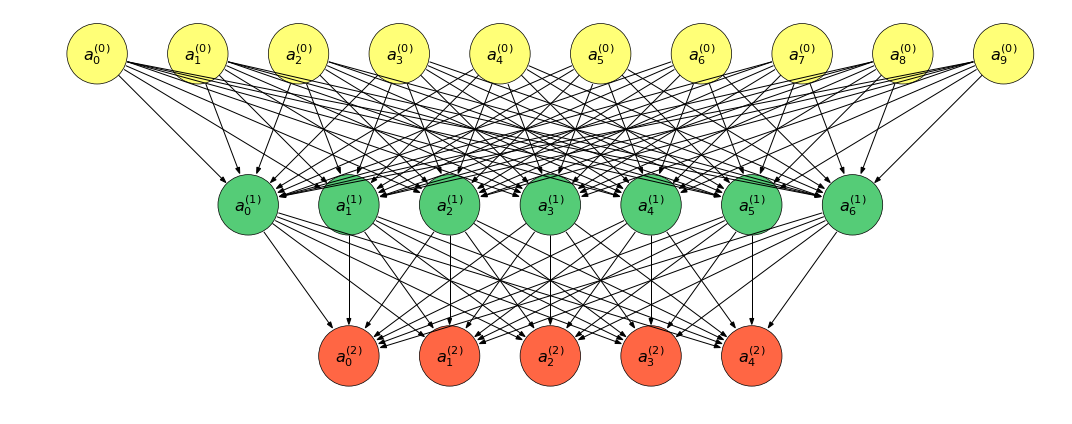

In [2]:
import sys

sys.path.append("E:/zlab/")
from plotnet import plot_net, DynamicShow

num_node_list = [10, 7, 5]
figsize = (15, 6)
plot_net(num_node_list, figsize, 'net')

上图转换为表达式：

$$
\begin{aligned}
&a^{(0)} = (a_0^{(0)}, a_1^{(0)}, \cdots, a_9^{(0)})^T\\
&a^{(1)} = (a_0^{(1)}, a_1^{(1)}, \cdots, a_6^{(1)})^T\\
&a^{(2)} = (a_0^{(2)}, a_1^{(2)}, \cdots, a_4^{(2)})^T\\
\end{aligned}
$$

对于任意的 $0 \leq i \leq 2$, 有前向传播的表达式：

$$
\begin{aligned}
&z^{(i+1)} = W^{(i)}a^{(i)} + b^{(i)}\\
&a^{(i+1)} = f^{(i+1)}(z^{(i+1)})
\end{aligned}
$$

其中，$f^{(j)}$ 表示激活函数，除了输出层外，一般使用 ReLU 函数；$W^{(i)}, b^{(i)}$ 为模型参数。

如若我们有 $m$ 个样本 $\{x^{(j)}\}_{j=1}^m$ 组成的数据集 $D$, 称 $X = (x^{(1)}, x^{(2)}, \cdots, x^{(m)})^T$ 为数据集 $D$ 的**设计矩阵**。

这样，前向传播可以改写为：

$$
\begin{cases}
Z^{(1+i)} = Z^{(i)}W^{(0)} + (b^{(i)})^T\\
A^{(1+i)} = f^{(1+i)}(Z^{(1+i)})
\end{cases}
$$

- $Z^{(i)} = (z_1^{(i)}, z_2^{(i)}, \cdots, z_m^{(i)})^T$, 这里对 $z^{(i)}$ 添加下标以区别不同的样本;
- 这里对列向量 $b^{(i)}$ 进行了 broadcast 操作;
- 且 $Z^{(0)} = X$.

对于多分类问题，一般输出层对应的激活函数的 softmax 函数：

求解 $A^{(2)}$:

1. 计算 $exp = \exp(Z^{(1)})$;
2. 对 $exp$ 按列做归一化, 便可得到 $\text{softmax}(A^{(1)})$.

In [66]:
import numpy as np

def softmax(X):
    X = np.asanyarray(X)
    X_exp = np.exp(X)
    partition = X_exp.sum(axis=-1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制。

In [67]:
softmax([[2, 3,4], [3, 5, 7]])

array([[0.09003057, 0.24472847, 0.66524096],
       [0.01587624, 0.11731043, 0.86681333]])

但如果输入值较大或较小时，会出现内存溢出的现象：

In [68]:
softmax([1000, 1000, 100])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


array([nan, nan,  0.])

In [69]:
softmax([-10000, -1020, 100, -70220])

array([0., 0., 1., 0.])

一种简单有效避免该问题的方法就是让 $\exp(z_j)$ 中的 $z_j$ 替换为 $z_j - \max_{i} \{z_i\}$, 由于 $\max_{i}$ 是个固定的常数，所以 $\exp(z_j)$ 的值没有改变。但是，此时避免了溢出现象的出现。

In [70]:
def softmax(X):
    X = np.asanyarray(X)
    X -= X.max(axis=-1, keepdims=True)
    X_exp = np.exp(X)
    print(X_exp)
    partition = X_exp.sum(axis=-1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制。

In [71]:
softmax([1000, 1000, 100])

[1. 1. 0.]


array([0.5, 0.5, 0. ])

In [72]:
softmax([-10000, -1020, 100, -7220])

[0. 0. 1. 0.]


array([0., 0., 1., 0.])

In [73]:
softmax([-10000, -1020, 100, -70220])

[0. 0. 1. 0.]


array([0., 0., 1., 0.])

当然这种做法也不是最完美的，因为 softmax 函数不可能产生 `0` 值，但这总比出现 `nan` 的结果好，并且真实的结果也是非常接近 $0$ 的。

除此之外，还有一个问题：如果我们计算 $\log \text{softmax} (z_j)$ 时，先计算 $\text{softmax}$ 再将其传递给 $\log$，会错误的得到 $-\infty$

In [83]:
np.log(softmax([-10000, -1020, 100, -70220]))

[0. 0. 1. 0.]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


array([-inf, -inf,   0., -inf])

最简单的处理方式是直接加一个很小的常数：

In [91]:
np.log(softmax([-10000, -1020, 100, -70220])+ 1e-7)

[0. 0. 1. 0.]


array([-1.61180957e+01, -1.61180957e+01,  9.99999951e-08, -1.61180957e+01])

为了解决此数值计算的不稳定，MXNet 提供了：

In [93]:
from mxnet.gluon import loss as gloss
loss = gloss.SoftmaxCrossEntropyLoss()

解决计算交叉熵时出现的数值不稳定的问题。